In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import wandb
import torch
import random
import pickle
import imageio
import librosa
import torchvision

import numpy as np
import pandas as pd
import torchmetrics as tm 
import plotly.express as px
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm

In [3]:
print('timm version', timm.__version__)
print('torch version', torch.__version__)

timm version 0.9.16
torch version 2.3.0


In [4]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [5]:
train_dir = Path('E:\data\BirdCLEF')

class CFG:
    DEBUG = False # True False

    # Competition Root Folder
    ROOT_FOLDER = train_dir
    AUDIO_FOLDER = train_dir / 'train_audio'
    UNLABELED_FOLDER = train_dir / 'unlabeled_soundscapes'
    DATA_DIR = train_dir / 'spectros'
    TRAN_CSV = train_dir / 'train_metadata.csv'
    RESULTS_DIR = train_dir / 'results'
    CKPT_DIR = train_dir / 'ckpt'

    num_workers = 12
    # Maximum decibel to clip audio to
    TOP_DB = 100
    # Minimum rating
    MIN_RATING = 3.0
    # Sample rate as provided in competition description
    SR = 32000

    image_size = 128
    
    ### split train and validation sets
    split_fraction = 0.95
    
    ### model
    model_name = 'eca_nfnet_l0' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...  
    
    ### training
    BATCH_SIZE = 128
    # N_EPOCHS = 3 if DEBUG else 40
    N_EPOCHS = 20
    LEARNING_RATE = 5*1e-6
    
    ### set only one to True
    save_best_loss = False
    save_best_accuracy = True
    
    ### optimizer
    #   optimizer = 'adam'
    # optimizer = 'adamw'
    optimizer = 'rmsprop'
    
    weight_decay = 1e-6 # for adamw
    l2_penalty = 0.01 # for RMSprop
    rms_momentum = 0 # for RMSprop
    
    ### learning rate scheduler (LRS)
    scheduler = 'ReduceLROnPlateau'
    #   scheduler = 'CosineAnnealingLR'
    plateau_factor = 0.5
    plateau_patience = 3
    cosine_T_max = 4
    cosine_eta_min = 1e-8
    verbose = True

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    random_seed = 42

    comment = 'first'

mel_spec_params = {
    "sample_rate": CFG.SR,
    "n_mels": 128,
    "f_min": 20,
    "f_max": CFG.SR / 2,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "mel_scale" : "slaney"
}

CFG.mel_spec_params = mel_spec_params

sample_submission = pd.read_csv(train_dir / 'sample_submission.csv')

# Set labels
CFG.LABELS = sample_submission.columns[1:]
CFG.N_LABELS = len(CFG.LABELS)
print(f'# labels: {CFG.N_LABELS}')

display(sample_submission.head())

# labels: 182


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [6]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

### Prepare dataframe

In [7]:
files = [f for f in sorted(os.listdir(CFG.UNLABELED_FOLDER))]
len(files)

8444

In [8]:
step = 5
ranges = np.arange(0+step, 240+step, step)
ranges

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240])

In [21]:
results_df = pd.DataFrame(files, columns = ['file'])
results_df['range'] = [ranges] * len(results_df)
# results_df.reset_index(drop=True, inplace=True)
results_df = results_df.explode('range', ignore_index=True)
# results_df.reset_index(drop=True, inplace=True)

In [33]:
pd.set_option('max_colwidth', 40)

In [40]:
results_df.head()

,file,range
0,1000170626.ogg,5
1,1000170626.ogg,10
2,1000170626.ogg,15
3,1000170626.ogg,20
4,1000170626.ogg,25


### Prepare dataset

In [11]:
from dataset import bird_dataset_inference, read_wav

In [12]:
files = [f for f in sorted(os.listdir(CFG.UNLABELED_FOLDER))]
len(files)

8444

In [13]:
files[0]

'1000170626.ogg'

In [14]:
file = CFG.UNLABELED_FOLDER / files[0]

wav = read_wav(file, CFG.SR)
wav.shape, wav.shape[1]/CFG.SR

(torch.Size([1, 7680000]), 240.0)

In [51]:
dset = bird_dataset_inference(files, CFG)
len(dset)

8444

In [52]:
spect = dset.__getitem__(0)

spect.dtype, spect.shape

(torch.float32, torch.Size([3, 128, 15001]))

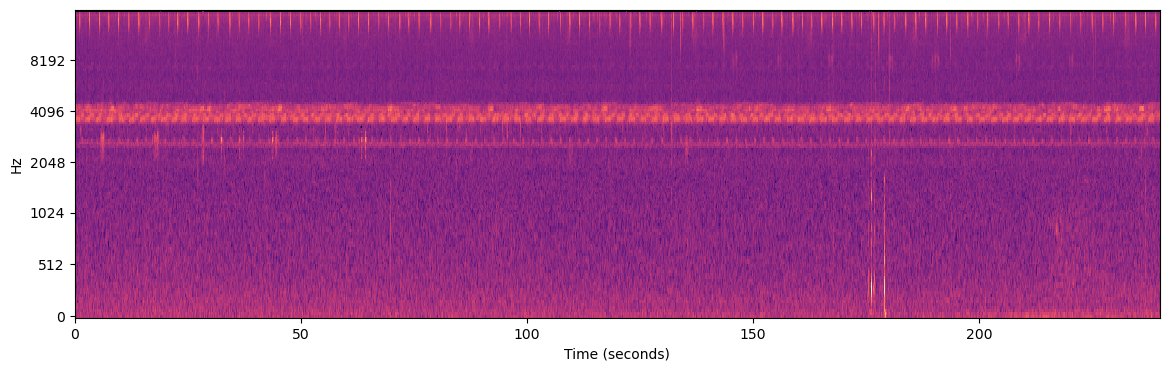

In [57]:
plt.figure(figsize=(14, 4))
librosa.display.specshow(spect[0].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

In [118]:
remainder = spect.shape[-1] % 48
spect.shape[-1] % 48, spect.shape[-1] // 48

(25, 312)

In [132]:
splits = torch.split(spect[:,:,:-remainder], 312, dim=-1)
len(splits), splits[0].shape, splits[-1].shape

(48, torch.Size([3, 128, 312]), torch.Size([3, 128, 312]))

In [135]:
splits = torch.stack(splits)
splits.shape

torch.Size([48, 3, 128, 312])

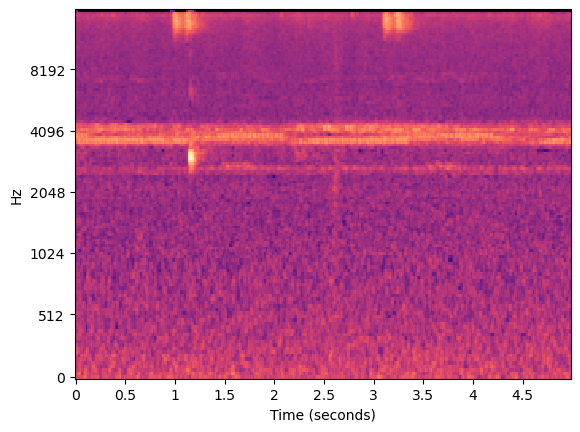

In [136]:
librosa.display.specshow(splits[0,0].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

In [12]:
for file in files:
    file = CFG.UNLABELED_FOLDER / file

    wav = read_wav(file)
    
    
    print(file)
    break

E:\data\BirdCLEF\unlabeled_soundscapes\1000170626.ogg


### Load model

### Predict